In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
    

In [17]:
class SimpleNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1, hidden_layers=4):
        super(SimpleNet, self).__init__()
        
        self.input_layer = nn.Linear(2*input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(hidden_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x0, x1 = x
        x = torch.cat([x0, x1], dim=1)
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x



In [18]:
class GeometricNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1):
        super(GeometricNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x0, x1 = x
        x0 = self.mlp(x0)
        x1 = self.mlp(x1)
        x = x0 - x1
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [52]:
f = lambda x0, x1: x0**3 + 5*x0**2 + 2*x0 - x1**3 - 5*x1**2 - 2*x1

def generate_data(n=1000, f=f):
    x0 = np.random.uniform(-0.5, 0.5, size=(n, 1))
    x1 = np.random.uniform(-0.5, 0.5, size=(n, 1))
    y = f(x0, x1)
    X = np.concatenate((x0, x1), axis=1)
    return X, y

X, y = generate_data(n = 20)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X.shape)
print(y.shape)

# train the network
def train(net, X, y, epochs=500, lr=0.001):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        x0 = torch.from_numpy(X[:, 0]).float().unsqueeze(1).float()
        x1 = torch.from_numpy(X[:, 1]).float().unsqueeze(1).float()
        y_pred = net((x0, x1))
        loss = loss_fn(y_pred, torch.from_numpy(y).float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def test_loss(net, X, y, swap=False):
    x0 = torch.from_numpy(X[:, 0]).float().unsqueeze(1).float()
    x1 = torch.from_numpy(X[:, 1]).float().unsqueeze(1).float()
    if swap:
        x0, x1 = x1, x0
        y = -y
    y_pred = net((x0, x1))
    loss_fn = nn.MSELoss()
    return loss_fn(y_pred, torch.from_numpy(y).float()).item()

def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# X_aug contains all samples of X and


(20, 2)
(20, 1)


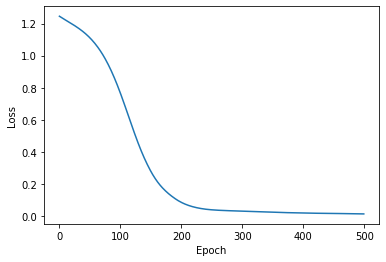

0.013139210641384125
0.013139210641384125
0.0074578216299414635
0.0074578216299414635


In [53]:
# train the network
geo_net = GeometricNet()
geo_losses = train(geo_net, X_train, y_train)
plot_losses(geo_losses)
print(test_loss(geo_net, X_train, y_train))
print(test_loss(geo_net, X_train, y_train, swap=True))
print(test_loss(geo_net, X_test, y_test))
print(test_loss(geo_net, X_test, y_test, swap=True))



In [41]:
# count parameters
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

count_parameters(geo_net)

160

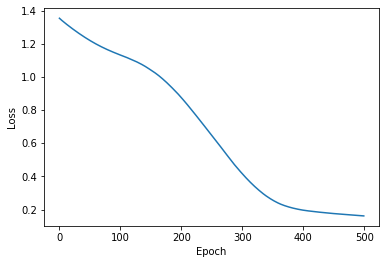

0.1612183302640915
0.39816930890083313
0.15620394051074982
0.14714395999908447


In [54]:
simple_net = SimpleNet(hidden_layers=2)
sim_losses = train(simple_net, X_train, y_train)
plot_losses(sim_losses)
print(test_loss(simple_net, X_train, y_train))
print(test_loss(simple_net, X_train, y_train, swap=True))
print(test_loss(simple_net, X_test, y_test))
print(test_loss(simple_net, X_test, y_test, swap=True))


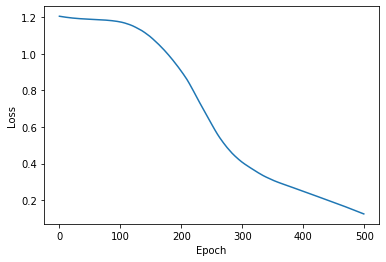

0.18810094892978668
0.08416587859392166
0.10186048597097397
0.14714395999908447


In [79]:
# augment the data by swapping the inputs
X_aug = np.concatenate((X, X[:, ::-1]), axis=0)
y_aug = np.concatenate((y, -y), axis=0)

simple_net_aug = SimpleNet(hidden_layers=2)
aug_losses = train(simple_net_aug, X_aug, y_aug)
plot_losses(aug_losses)
print(test_loss(simple_net_aug, X_train, y_train))
print(test_loss(simple_net_aug, X_train, y_train, swap=True))
print(test_loss(simple_net_aug, X_test, y_test))
print(test_loss(simple_net, X_test, y_test, swap=True))

In [24]:
count_parameters(simple_net)

177

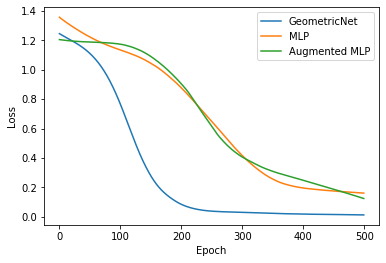

In [80]:
# plot all losses together
plt.plot(geo_losses, label='GeometricNet')
plt.plot(sim_losses, label='MLP')
plt.plot(aug_losses, label='Augmented MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()